# Simulating Rainbow Trades

We need to demonstrate the ability to detect normal & abnormal trading behaviour of clients and client groups (client profiling & anomaly detection). 

We also want to be able to flag trade sequences that are similar to known 'fraudulent activity' (classification).

Finally, we want to demonstrate the ability to predict trading behaviour of clients or groups of clients.

Given the above requirements we will create the following data:

* Referential data that identifies some arbitrary grouping for each client
* Ficticious trades - let's call then "Rainbow Trades" - that have 3 varying attributes - Red, Green & Blue mix that allows us to easily visualise trades in 3 dimensional space and to create classification labels
* Noise will be added to the RGB value to allow us to create "similar" but not identical trades
* Different sequences of ficticious trades will be created for each group of clients, (e.g. Red, Green, Orange, Red, Green Orange .....) to facilitate learning temporal behaviour and prediction
* Changes in sequences of ficticious trades will be introduced to facilitate the detection of abnormalities

### Simulate client referential

In [1]:
# six clients in 3 groups - 'sectors'
#
clients = {'ABC_Ltd': {'group': 'construction', 'pattern': True, 'noise': 0.2, 
                       'normal_repeat':20, 'normal_dist': ['RED', 'BLUE', 'YELLOW'], 
                       'anomaly_repeat': 1, 'anomaly_dist': ['GREEN']},
           
           'DEF_Ltd': {'group': 'construction', 'pattern': True, 'noise': 0.2, 
                       'normal_repeat':20,  'normal_dist': ['RED', 'BLUE', 'YELLOW'], 
                       'anomaly_repeat': 20, 'anomaly_dist': ['GREEN','BROWN', 'BLACK']},
           
           'GHI_Ltd': {'group': 'ecommerce', 'pattern': True, 'noise': 0.2, 
                       'normal_repeat':10, 'normal_dist':['PURPLE', 'GREEN', 'ORANGE', 'GREY', 'BROWN', 'RED', 'BLUE', 'YELLOW'],
                       'anomaly_repeat': 3, 'anomaly_dist':['BLACK']},
           
           'JKL_Ltd': {'group': 'ecommerce', 'pattern': True, 'noise': 0.2, 
                       'normal_repeat':10, 'normal_dist':['PURPLE', 'GREEN', 'ORANGE', 'GREY', 'BROWN', 'RED', 'BLUE', 'YELLOW'],
                       'anomaly_repeat': 3, 'anomaly_dist':['BLACK']},
           
           'MNO_Ltd': {'group': 'car_manufacturer', 'pattern': False, 'noise': 0.2, 
                       'normal_repeat':20, 'normal_dist': ['RED', 'BLUE', 'YELLOW'], 
                       'anomaly_repeat': 10, 'anomaly_dist': ['RED', 'BLUE', 'YELLOW']},
           
           'PQR_Ltd': {'group': 'car_manufacturer', 'pattern': False, 'noise': 0.2, 
                       'normal_repeat':20, 'normal_dist': ['RED', 'BLUE', 'YELLOW'], 
                       'anomaly_repeat': 10, 'anomaly_dist': ['RED', 'BLUE', 'YELLOW']},
           }

# create map of clients in each group
#
groups = {}
for client in clients:
    if clients[client]['group'] not in groups:
        groups[clients[client]['group']] = [client]
    else:
        groups[clients[client]['group']].append(client)
groups

{'construction': ['ABC_Ltd', 'DEF_Ltd'],
 'ecommerce': ['GHI_Ltd', 'JKL_Ltd'],
 'car_manufacturer': ['MNO_Ltd', 'PQR_Ltd']}

## Simulate the Rainbow Trades

In [2]:
# use standard random library to generate random numbers
#
import random

# so we can always repeat the experiment
#
random.seed(221166)


# standard RGB colours (red, green, blue)

rgb = {'RED': (255, 0, 0),
       'ORANGE': (255, 129, 0),
       'YELLOW': (255, 233, 0),
       'GREEN': (0, 202, 14),
       'BLUE': (22, 93, 239),
       'PURPLE': (166, 1, 214),
       'BROWN': (151, 76, 2),
       'GREY': (128, 128, 128),
       'BLACK': (0, 0, 0),
       'TURQUOISE': (150, 255, 255)}

# keep track of stats and sequence types for each client
#
client_state = {}

# maximum amount of noise is 5% of the max value of 255
#
noise = 255 * 0.15

# the data for training
#
simulated_data = []

# the unique trade id
#
trade_id = 0
while trade_id < 1000:
    
    # get the group
    #
    group = random.choice(list(groups.keys()))
    
    # get the client
    #
    client_idx = random.randint(0, 1)
    client = groups[group][client_idx]


    # keep track of the client state
    #
    if client not in client_state:
        # create the client_state record
        #
        client_state[client] = {'nos_sequences': 1,
                                'nos_trades':0,
                                'seq_idx': 0,
                                'state': 'normal',
                                'pattern': clients[client]['pattern'],
                                'anomaly_seq': None,
                                'normal_dist': clients[client]['normal_dist'],
                                'anomaly_dist': clients[client]['anomaly_dist'],
                                'noise': clients[client]['noise']
                                }
    
    # keep trake of number of trades for client
    #
    client_state[client]['nos_trades'] += 1
    
    
    # choose the sequence to use - which depends on if we are using an anomalous, fraudulent or normal sequence
    #
    if client_state[client]['state'] == 'anomaly':
        
        sequence = clients[client]['anomaly_dist']
        
        if client_state[client]['seq_idx'] == 0 and 'anomaly_trade_id' not in client_state[client]:
            client_state[client]['anomaly_trade_id'] = trade_id
            client_state[client]['anomaly_trade_offset'] = client_state[client]['nos_trades'] - 1
    
        # get the colour of the rainbow trade - either in sequence or randomly
        #
        if not clients[client]['pattern']:
            rainbow_trade_colour = sequence[client_state[client]['seq_idx']]
        else:
            rainbow_trade_colour = random.choice(sequence)
    
        # move index for client and wrap if required
        #
        client_state[client]['seq_idx'] += 1

        if client_state[client]['seq_idx'] >= len(sequence):
            client_state[client]['seq_idx'] = 0
            client_state[client]['nos_sequences'] += 1
            client_state[client]['anomaly_seq'] += 1
            
            # change back state if required
            #
            if client_state[client]['anomaly_seq'] > clients[client]['anomaly_repeat']: 
                client_state[client]['state'] = 'normal'
      
    else:
        # must be normal
        #
        sequence = client_state[client]['normal_dist']
    
        if 'anomaly_trade_id' in client_state[client] and 'normal_trade_id' not in client_state[client]:
            client_state[client]['normal_trade_id'] = trade_id
            client_state[client]['normal_trade_offset'] = client_state[client]['nos_trades'] - 1
    
        # get the colour of the rainbow trade - either in sequence or randomly
        #
        if clients[client]['pattern']:
            rainbow_trade_colour = sequence[client_state[client]['seq_idx']]
        else:
            rainbow_trade_colour = random.choice(sequence)
        
        # move index for client and wrap if required
        #
        client_state[client]['seq_idx'] += 1

        if client_state[client]['seq_idx'] >= len(sequence):
            client_state[client]['seq_idx'] = 0
            client_state[client]['nos_sequences'] += 1
                
            # if first normal sequences have been completed then transition to anomaly
            #
            if client_state[client]['anomaly_seq'] is None and client_state[client]['nos_sequences'] > clients[client]['normal_repeat']: 
                client_state[client]['state'] = 'anomaly'
                client_state[client]['anomaly_seq'] = 1
        
           
    # trade is a simple dictionary of: 
    #     trade_id
    #     client
    #     label
    #     r
    #     g
    #     b
    #
    trade = {'trade_id': trade_id, 'client': client, 'label': rainbow_trade_colour}

    # calc some noise and modify the RGB component of this colour
    #
    rnd = random.random()
    noise_delta = 255 * clients[client]['noise'] * rnd 
    if rnd >= 0.5:
        trade['r'] = int(min(rgb[rainbow_trade_colour][0] + noise_delta, 255))
    else:
        trade['r'] = int(max(rgb[rainbow_trade_colour][0] - noise_delta, 0))

    # same for green
    #
    rnd = random.random()
    noise_delta = 255 * clients[client]['noise'] * rnd 
    if rnd >= 0.5:
        trade['g'] = int(min(rgb[rainbow_trade_colour][1] + noise_delta, 255))
    else:
        trade['g'] = int(max(rgb[rainbow_trade_colour][1] - noise_delta, 0))

    # same for blue
    #
    rnd = random.random()
    noise_delta = 255 * clients[client]['noise'] * rnd  
    if rnd >= 0.5:
        trade['b'] = int(min(rgb[rainbow_trade_colour][2] + noise_delta, 255))
    else:
        trade['b'] = int(max(rgb[rainbow_trade_colour][2] - noise_delta, 0))

    # add the trade
    #
    simulated_data.append(trade)
    
    # inc trade_id
    #
    trade_id += 1

print(len(simulated_data))
client_state

1000


{'DEF_Ltd': {'nos_sequences': 59,
  'nos_trades': 175,
  'seq_idx': 1,
  'state': 'normal',
  'pattern': True,
  'anomaly_seq': 21,
  'normal_dist': ['RED', 'BLUE', 'YELLOW'],
  'anomaly_dist': ['GREEN', 'BROWN', 'BLACK'],
  'noise': 0.2,
  'anomaly_trade_id': 363,
  'anomaly_trade_offset': 60,
  'normal_trade_id': 703,
  'normal_trade_offset': 120},
 'JKL_Ltd': {'nos_sequences': 25,
  'nos_trades': 178,
  'seq_idx': 7,
  'state': 'normal',
  'pattern': True,
  'anomaly_seq': 4,
  'normal_dist': ['PURPLE',
   'GREEN',
   'ORANGE',
   'GREY',
   'BROWN',
   'RED',
   'BLUE',
   'YELLOW'],
  'anomaly_dist': ['BLACK'],
  'noise': 0.2,
  'anomaly_trade_id': 460,
  'anomaly_trade_offset': 80,
  'normal_trade_id': 490,
  'normal_trade_offset': 83},
 'ABC_Ltd': {'nos_sequences': 59,
  'nos_trades': 172,
  'seq_idx': 0,
  'state': 'normal',
  'pattern': True,
  'anomaly_seq': 2,
  'normal_dist': ['RED', 'BLUE', 'YELLOW'],
  'anomaly_dist': ['GREEN'],
  'noise': 0.2,
  'anomaly_trade_id': 339,


## We will make use of Plotly to visualise what is going on

Below is a plot of the timeseries of colours we have created

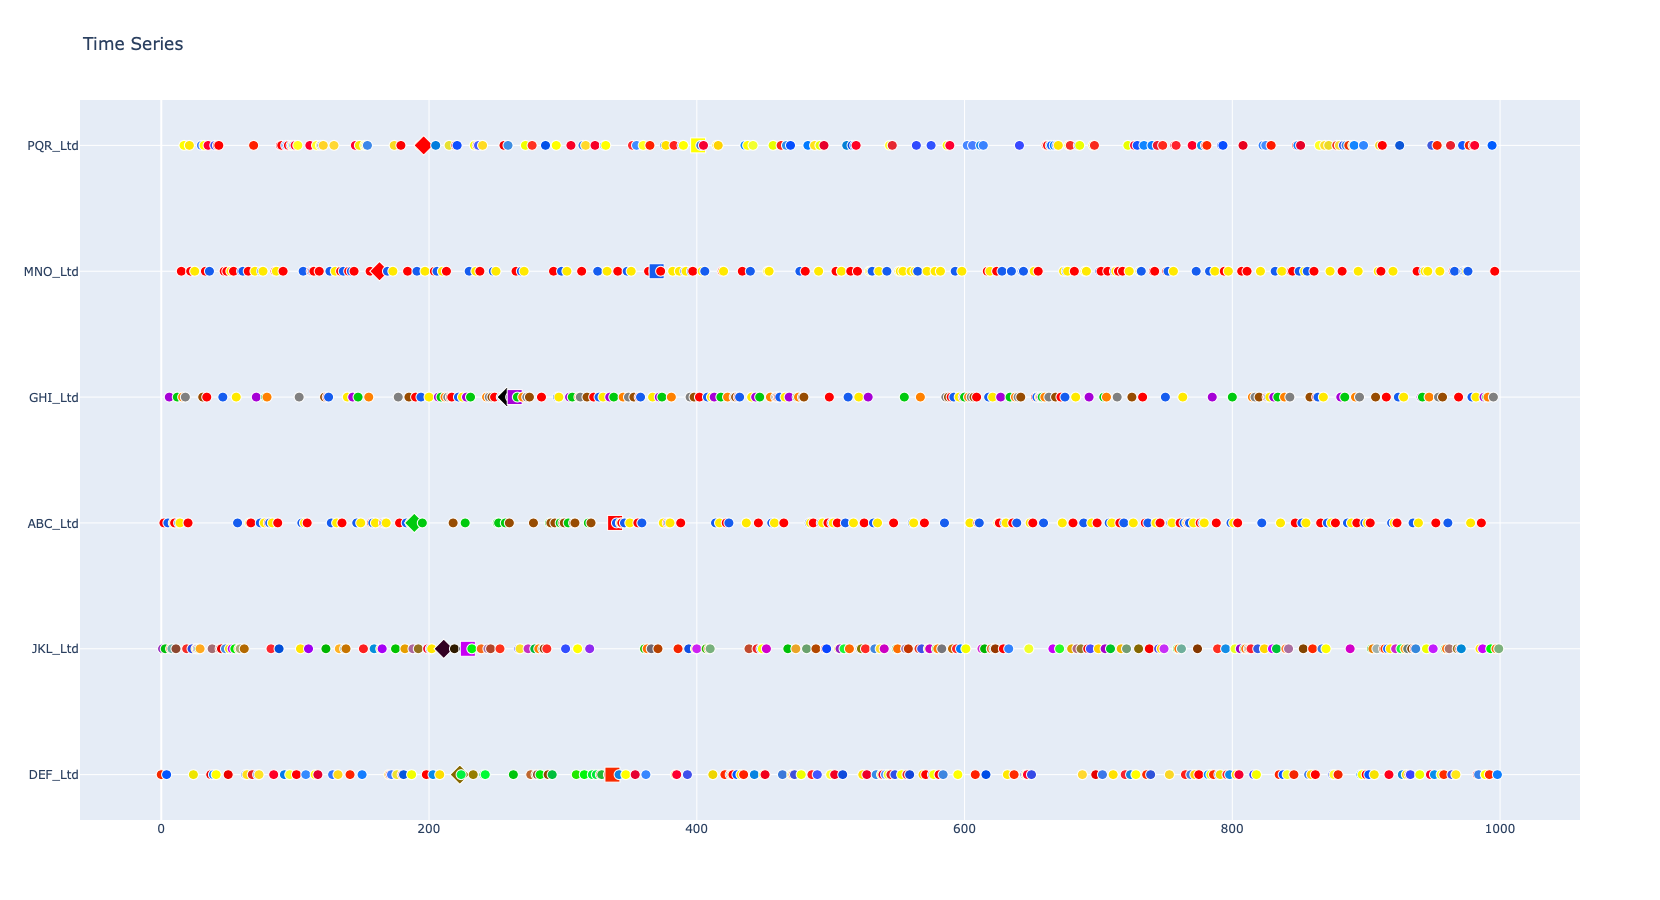

In [26]:
# library to plot data
#
import plotly.graph_objects as go


# lists to hold x y coordinates of each Rainbow Trade
#
x = []
y = []

# list of RGB colours for each Rainbow Trade
#
colours = []

# list of labels to be displayed when mouse hovers over a Rainbow Trade
#
labels = []

# size of plot for each Rainbow Trade
#
size = []

# the type of marker per trade
#
symbol = []

for trade_id in range(len(simulated_data)):

    # a coloured blob for each trade
    #
    x.append(trade_id)
    y.append(simulated_data[trade_id]['client'])
    
    if ('anomaly_trade_id' in client_state[simulated_data[trade_id]['client']] and client_state[simulated_data[trade_id]['client']]['anomaly_trade_id'] == trade_id):
        
        size.append(15)
        
        symbol.append('diamond')
        
        trade_class = 'ABNORMAL'
    
    elif ('normal_trade_id' in client_state[simulated_data[trade_id]['client']] and client_state[simulated_data[trade_id]['client']]['normal_trade_id'] == trade_id):
        
        size.append(15)
        
        symbol.append('square')
        
        trade_class = 'NORMAL'
        
    else:
        size.append(10)
        symbol.append('circle')
        trade_class = ''

        
    # specify the hover text
    #
    labels.append('client: {} r: {} g: {} b: {} {}'.format(simulated_data[trade_id]['client'], simulated_data[trade_id]['r'], simulated_data[trade_id]['g'], simulated_data[trade_id]['b'], trade_class))
        
    # specify the colour for this blob
    #
    colours.append('rgb({},{},{})'.format(simulated_data[trade_id]['r'], simulated_data[trade_id]['g'], simulated_data[trade_id]['b']))
    
    
# the coloured points
#
ts_points = go.Scatter(x=x, y=y, hovertext=labels, mode='markers', marker=dict(size=size, color=colours, opacity=1.0, symbol=symbol))

# a plot consists of a figure object
#
fig = go.Figure(data=[ts_points])
fig.update_layout(width=2000, height=900, title=dict(text='Time Series'))
fig.show()

## Save Data to JSON file

In [3]:
# library to read / write json
#
import json

file_name= '../data/example_clients.json'
with open(file_name, 'w') as fp:
    json.dump(clients, fp, indent=4)           

file_name= '../data/rainbow_trades.json'
with open(file_name, 'w') as fp:
    json.dump(simulated_data, fp, indent=4)
        
file_name= '../data/client_stats.json'
with open(file_name, 'w') as fp:
    json.dump(client_state, fp, indent=4)